# Démontration [Scikit-learn](https://scikit-learn.org/stable/index.html)

---

## Mise en situation

- Données: AdventureWorks 2019 (clients ayant une adressse de facturation aux États-Unis)


- Mandat: Détermine quel genre de clientèle fait l'achat d'un vélo. 


- Problématique: Classification binaire (oui ou non)


- Variables explicatives:
`'DateFirstPurchase', 'BirthDate', 'MaritalStatus', 'YearlyIncome', 'Gender', 'TotalChildren','NumberChildrenAtHome', 'Education','Occupation', 'HomeOwnerFlag', 'NumberCarsOwned', 'AvgPurchase'`


- Modèles statistiques ajustés: Régression logistique, forêt aléatoire et machine à vecteurs de support (support vector machine- SVM)


- Entraînement: Utilisation de `sklearn.pipeline()` afin de combiner différentes étapes de la modélisation.


- Prétraitement/Preprocessing: Utilisation de `StandardScaler()` sur les variables numériques & Utilisation de `OneHotEncoder()` sur les variables catégoriques.


- Trouver les meilleurs hyperparamètres/Model selection: Utilisation de `GridSearchCV()` et comme mesure de performance la *précision*.


- Réentraîner les modèles (LR, RF, SVM) sur toute les donnnées avec les meilleurs hyperparamètres et comparer leur performance: Utilisation de `cross_val_score()`


- Performance du meilleur modèle


# Step 1: Importing libraries

In [1]:
### Common librairies ###

import pandas as pd # data manipulation tool
import numpy as np # scientific computing
from datetime import datetime # parsing dates
from datetime import date # parsing dates
import time # Time elapse evaluation
import joblib # Saving models
import seaborn as sns # making graphs

### Building a Pipeline ###

# Model Selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Comparing performance
from sklearn import metrics


### Models for predictive data analysis ###

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 

# Setting seeds
np.random.seed(0)

# Step 2: Loading data in notebook

In [2]:
# Importing data
data = pd.read_csv('/Users/emiliehamel/OneDrive_HEC/HEC/tech/scikitlearn/data/data.csv', header=None,
                   usecols = list(range(2,15)),
                  names=['ID', 'TotalPurchaseYTD', 'DateFirstPurchase', 'BirthDate', 'MaritalStatus',
                         'YearlyIncome', 'Gender', 'TotalChildren','NumberChildrenAtHome', 'Education',
                         'Occupation', 'HomeOwnerFlag', 'NumberCarsOwned', 'TotalPurchase', 'y', 'ID2' ]
                  )
# Preview data
data.head()

,DateFirstPurchase,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,TotalPurchase,y
0,2004-05-27 00:00:00.000,1942-02-18 00:00:00.000,M,greater than 100000,F,2,4,Graduate Degree,Management,0,3,81.26,Non
1,2003-08-06 00:00:00.000,1942-06-20 00:00:00.000,M,25001-50000,M,1,0,Bachelors,Clerical,1,0,113.96,Non
2,2003-07-24 00:00:00.000,1977-11-27 00:00:00.000,S,25001-50000,F,0,0,Partial High School,Clerical,0,2,138.45,Non
3,2003-01-02 00:00:00.000,1972-11-03 00:00:00.000,M,75001-100000,M,0,0,Bachelors,Professional,1,3,2500.97,Oui
4,2004-06-28 00:00:00.000,1962-09-21 00:00:00.000,M,50001-75000,F,1,0,Partial College,Skilled Manual,1,1,2332.28,Oui


# Step 3: Data Preparation

In [3]:
# Defining function to extract age from birthdate
def calculate_age(born):
    born = datetime.strptime(born, "%Y-%m-%d %H:%M:%S.%f").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# Replacing date values with approximation of customer's age
data['BirthDate'] = data['BirthDate'].apply(calculate_age)

In [5]:
# Defining function to calculate mean spending per year
def calculate_avg_spending(date):
#     date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f").date()
    date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f").date().year
    return date 

 
data.DateFirstPurchase = pd.to_numeric(data['DateFirstPurchase'].apply(calculate_avg_spending))
data['AvgPurchase'] = data.TotalPurchase / ((max(data.DateFirstPurchase) - data.DateFirstPurchase) + 1)

In [4]:
# Formatting ordinal features (numerical columns)

# YearlyIncome
data.YearlyIncome.replace({'0-25000': 1,
                           '25001-50000': 2,
                           '50001-75000': 3,
                           '75001-100000': 4,
                           'greater than 100000': 5},inplace=True)
# Education
data.Education.replace({'Partial High School': 1,
                           'High School': 2,
                           'Partial College': 3,
                           'Bachelors ': 4,
                           'Graduate Degree': 5},inplace=True)
# Target
data.y.replace({'Oui': 1,'Non': 0,},inplace=True)



In [6]:
# Preview data before modelling
data.head()

,DateFirstPurchase,BirthDate,MaritalStatus,YearlyIncome,Gender,TotalChildren,NumberChildrenAtHome,Education,Occupation,HomeOwnerFlag,NumberCarsOwned,TotalPurchase,y,AvgPurchase
0,2004,79,M,5,F,2,4,5,Management,0,3,81.26,0,81.260
1,2003,78,M,2,M,1,0,4,Clerical,1,0,113.96,0,56.980
2,2003,43,S,2,F,0,0,1,Clerical,0,2,138.45,0,69.225
3,2003,48,M,4,M,0,0,4,Professional,1,3,2500.97,1,1250.485
4,2004,58,M,3,F,1,0,3,Skilled Manual,1,1,2332.28,1,2332.280


In [7]:
print(f'Our final dataset contains {data.shape[0]} rows and {data.shape[1]} columns.')

Our final dataset contains 4214 rows and 14 columns.


In [8]:
# Features
X = data.iloc[:,[1,2,3,4,5,6,7,8,9,10,13]]

# Target 
y = data['y']

# Step 4: Quick descriptive analysis

In [9]:
X.describe()

,BirthDate,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,HomeOwnerFlag,NumberCarsOwned,AvgPurchase
count,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000,4214.000000
mean,58.755102,2.724964,1.863787,1.044139,3.303037,0.677029,1.503085,836.833199
std,11.145364,1.177186,1.626669,1.543559,1.208603,0.467667,1.155741,1274.940876
min,40.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.247500
25%,50.000000,2.000000,0.000000,0.000000,2.000000,0.000000,1.000000,30.426667
50%,57.000000,3.000000,2.000000,0.000000,3.000000,1.000000,2.000000,108.460000
75%,66.000000,3.000000,3.000000,2.000000,4.000000,1.000000,2.000000,1194.977500
max,108.000000,5.000000,5.000000,5.000000,5.000000,1.000000,4.000000,6704.080000


# Step 5: Statistical modelling

In [10]:
# Dataset partitioning 90/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

<img src="img/pipeline.png" width=1300 height=1000 />

In [12]:
# Pre-processing

numeric_features = ['AvgPurchase']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


categorical_features = ['MaritalStatus', 'Gender', 'Occupation',
                       'HomeOwnerFlag']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [13]:
# Defining pipeline for models

# Logistic regression
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', LogisticRegression( random_state=42))])


# Random forest
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', RandomForestClassifier(random_state=42))])

# SVM
pipe_svm = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', svm.SVC(random_state=42))])

In [19]:
# Creating dictionary with candidate learning algorithms and their hyperparameters

search_space = [{"clf": [LogisticRegression()],
                 "clf__solver": ['newton-cg', 'lbfgs'],
                 "clf__C": np.logspace(0, 4, 20)},
                
                {"clf": [RandomForestClassifier()],
                 "clf__n_estimators": np.linspace(500, 1000, 6, endpoint=True, dtype=int),
                "clf__max_features": np.linspace(2, 10, 5, endpoint=True, dtype=int)},
                
                {"clf": [svm.SVC()],
                 "clf__kernel": ['linear'],
                "clf__C": [1, 10, 100]}]


In [20]:
# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_rf, pipe_svm]
models_names = ['lr', 'rf', 'svm']
best_models = []
scores = []

# Fit the pipelines
start = time.time() #start timer

for idx, pipe in enumerate(pipelines):
    
    # Create grid search to find best parameters
    my_clf = GridSearchCV(pipe, search_space[idx], cv=3, refit=True, scoring='accuracy', verbose=1)
    
    # Fit grid search on whole dataset
    my_clf_fitted = my_clf.fit(X_train, y_train)
    clf = my_clf_fitted.best_estimator_.set_params()
    joblib.dump(clf, f'best_{models_names[idx]}.pkl', compress = 1)
    
    # Conduct nested cross-validation and output the avg. score of the best model
    score = cross_val_score(my_clf, X_train, y_train, scoring="accuracy").mean()
    scores.append(score)

end = time.time() # end timer
print(f'Training Successful\n\n'
      f'Elapse time: {end - start}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.8min finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.6min finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.6min finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.6min finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.6min finished


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.6min finished


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Training Successful

Elapse time: 619.8151390552521


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s finished


# Step 6: Selecting best model 

In [21]:
# Create score table and save results into csv
score_tbl= pd.DataFrame(zip(models_names,
                 np.transpose(scores)),
             columns=['model', 'score'])

# score_tbl.to_csv(f'score_tbl.csv')
score_tbl

,model,score
0,lr,0.990769
1,rf,0.991824
2,svm,0.992616


In [1]:
# Visualize tuned model performance
# sns.barplot(models_names, scores)

# Step 7: Best model Performance

In [23]:
# Loading the model
loaded_model = joblib.load(f'best_svm.pkl')
print("Model score on test set: %.3f" % loaded_model.score(X_test, y_test))

Model score on test set: 0.986


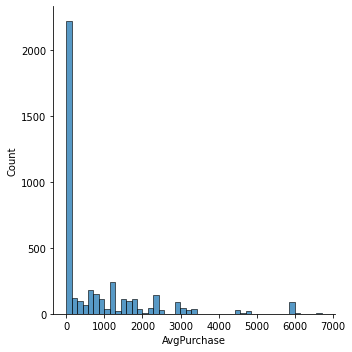

In [24]:
sns.displot(data, x="AvgPurchase")